In [1]:

import os
#os.environ["XLA_FLAGS"] = (
#    "--xla_gpu_strict_conv_algorithm_picker=false "
#    "--xla_gpu_enable_cudnn_frontend=false "
#    "--xla_gpu_autotune_level=0"
#)
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"
os.environ["JAX_PLATFORMS"] = "cuda"  # or: os.environ["JAX_PLATFORM_NAME"]="cuda"
#using GPU, comment out if on CPU?
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import jax
jax.config.update("jax_disable_jit", False)

jax.config.update("jax_debug_nans", True)
print(jax.lib.xla_bridge.get_backend().platform_version)  # sanity: shows CUDA/cuDNN


PJRT C API
cuda 12030


/tmp/ipykernel_3701083/2709273283.py:17: DeprecationWarning: jax.lib.xla_bridge.get_backend is deprecated; use jax.extend.backend.get_backend.
  print(jax.lib.xla_bridge.get_backend().platform_version)  # sanity: shows CUDA/cuDNN


In [2]:
#load athena ICs
import h5py
import jax.numpy as jnp
from diffhydro.utils.io import athinput,athdf

athena_outputs_loc = "/gpfs02/work/bhorowitz/sims/blast_mhd/"

ic_filename = "Blast_MHD.out1.00000.athdf"


ICs = athdf(athena_outputs_loc+ic_filename)


In [3]:
#some strange index conventions, need to double check these...
import jax.numpy as jnp
sol = jnp.zeros((8,64,64,64))

sol = sol.at[0].set(ICs["rho"])
sol = sol.at[1].set(ICs["vel2"])
sol = sol.at[2].set(ICs["vel1"])
sol = sol.at[3].set(ICs["vel3"])

sol = sol.at[4].set(ICs["Bcc2"])
sol = sol.at[5].set(ICs["Bcc1"])
sol = sol.at[6].set(ICs["Bcc3"])

sol = sol.at[-1].set(ICs["press"])

2025-10-24 21:07:00.792635: W external/xla/xla/service/gpu/nvptx_compiler.cc:893] The NVIDIA driver's CUDA version is 12.6 which is older than the PTX compiler version 12.9.86. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [4]:
import diffhydro as dh


In [5]:
eq = dh.equationmanager_mhd.EquationManagerMHD()
#eq = dh.equationmanager.EquationManager()

In [6]:
from diffhydro.solver.riemann_solver import RiemannSolver

In [7]:
ic = eq.get_conservatives_from_primitives(sol)

In [8]:
#eq = EquationManagerMHD()              # provides get_fast_magnetosonic_speed, get_fluxes_xi (MHD)
#solver = dh.HLLC(equation_manager=eq) # signal_speed not needed here
#cf = dh.ConvectiveFlux(eq, solver, dh.MUSCL3(limiter="VANLEER"))
ss = dh.signal_speed_Rusanov
#solver = dh.HLLC(equation_manager=eq,signal_speed=ss)
solver = dh.HLL_MHD(equation_manager=eq,signal_speed=ss)

cf = dh.ConvectiveFlux(eq,solver,dh.MUSCL3(limiter="SUPERBEE"),positivity=False)
hydro = dh.hydro(n_super_step=90, fluxes=[cf], use_mol=True, integrator="SSPRK3")

In [9]:
params = {}
output = hydro.evolve(sol,params)

dt [Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=1/0)>, 10000000000.0]


In [10]:
field_out = output[0]

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


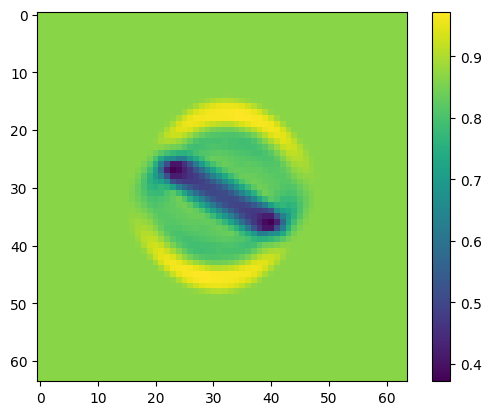

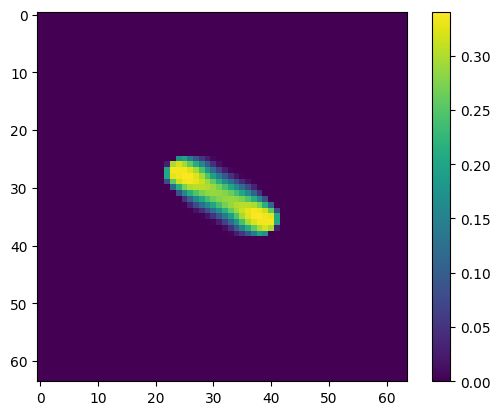

In [11]:
%pylab inline

field_out_prim = eq.get_primitives_from_conservatives(field_out)
imshow(field_out_prim[5][:,:,32])
colorbar()
show()
imshow(field_out_prim[-1][:,:,32])
colorbar()

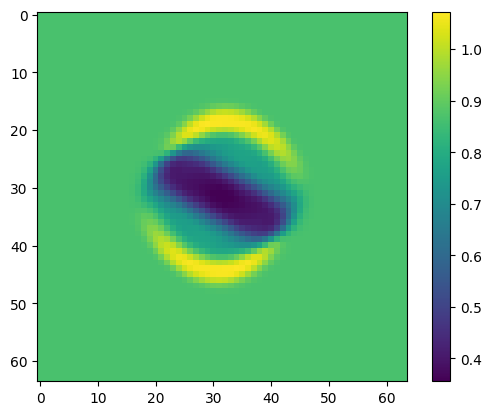

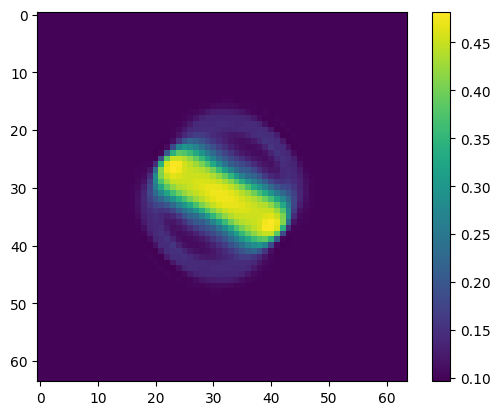

In [12]:

fc_filename = "Blast_MHD.out1.00002.athdf"

FCs = athdf(athena_outputs_loc+fc_filename)
imshow(FCs["Bcc1"][32])
colorbar()
show()
imshow(FCs["press"][32])
colorbar()
show()

In [13]:
#HLL_MHD is very diffusive! Not surprising... lets use HLLD!

In [15]:
eq.cfl = 0.30
#ss = dh.signal_speed_Rusanov #i d
solver = dh.HLLD_MHD(equation_manager=eq,signal_speed=ss)

cf = dh.ConvectiveFlux(eq,solver,dh.MUSCL3(limiter="SUPERBEE"),positivity=False)
hydro = dh.hydro(n_super_step=90, fluxes=[cf], use_mol=True, integrator="SSPRK3",maxjit=False)

In [16]:
params = {}
output = hydro.evolve(sol,params)

dt [Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=1/0)>, 10000000000.0]


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


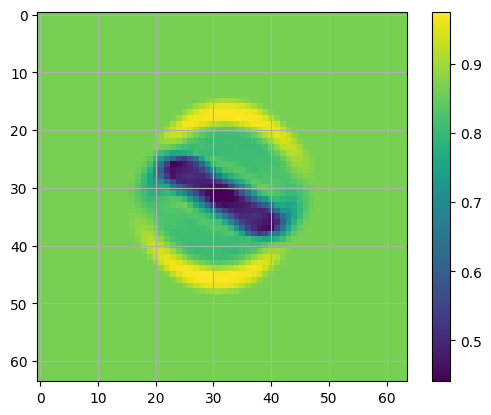

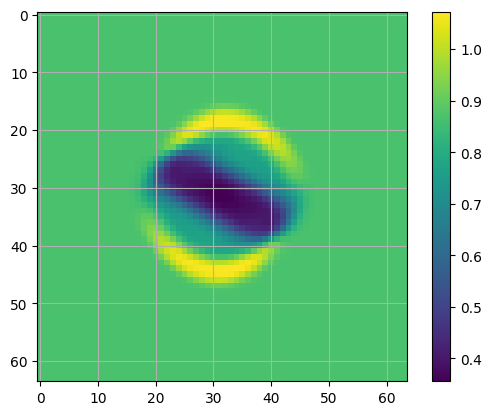

In [21]:
%pylab inline
field_out = output[0]
field_out_prim = eq.get_primitives_from_conservatives(field_out)
imshow(field_out_prim[5][:,:,32])
grid()
colorbar()
show()
imshow(FCs["Bcc1"][32])
grid()
colorbar()
show()

In [22]:
#not that much better, need MHD expert! Probably need to use GLM... sigh...

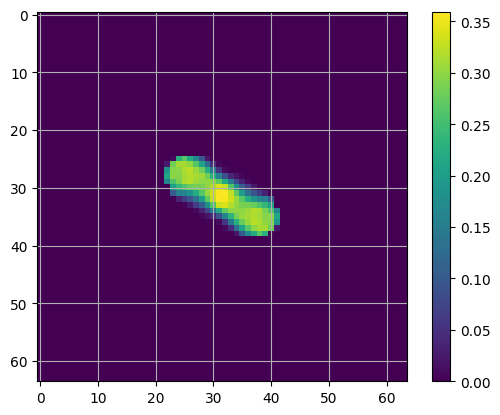

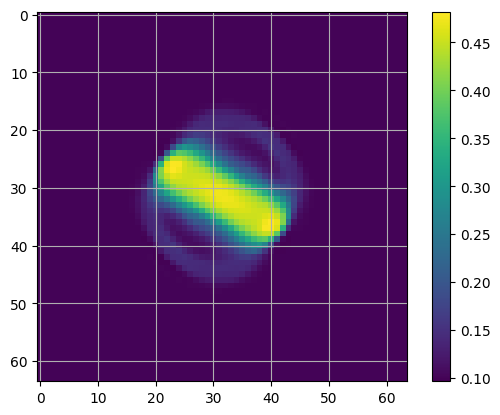

In [23]:
imshow(field_out_prim[-1][:,:,32])
grid()
colorbar()
show()
imshow(FCs["press"][32])
grid()
colorbar()
show()